In [258]:
import geopandas as gpd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

gm = gpd.read_parquet('data/gemeenten/gemeenten_stats.parquet')
wk = gpd.read_parquet('data/wijken/wijken_stats.parquet')
bu = gpd.read_parquet('data/buurten/buurten_stats.parquet')

In [259]:
# Matches all entropy columns
for gdf in [gm, wk, bu]:
    regex = re.compile(r'L\d{1}_(shannon|altieri|leibovici)_\d{1}') 

    cols = [col for col in gdf.columns if regex.match(col)]
    cols

    for col in cols:
        gdf.loc[:, f'{col}_T'] = gdf[col] / (np.emath.logn(5, gdf.STED) + 1)
        gdf.loc[:, f'{col}_norm'] = (gdf[col] - gdf[col].min()) / (gdf[col].max() - gdf[col].min())
        
gdf.head(3)

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,...,L1_shannon_0_T,L1_shannon_0_norm,L0_shannon_1_T,L0_shannon_1_norm,L1_shannon_1_T,L1_shannon_1_norm,L0_shannon_2_T,L0_shannon_2_norm,L1_shannon_2_T,L1_shannon_2_norm
0,BU00140000,Binnenstad-Noord,WK001400,GM0014,Groningen,1.0,NEE,9712,1.0,6865.0,...,4.293813,0.923831,1.961034,0.604057,3.911162,0.856103,2.147853,0.689335,3.749752,0.871942
1,BU00140001,Binnenstad-Zuid,WK001400,GM0014,Groningen,1.0,NEE,9711,1.0,6586.0,...,4.329074,0.931418,2.005446,0.617737,3.991515,0.873691,2.125112,0.682036,3.806012,0.885024
2,BU00140002,Binnenstad-Oost,WK001400,GM0014,Groningen,1.0,NEE,9711,3.0,6264.0,...,4.287841,0.922546,2.365702,0.728707,3.974084,0.869875,2.453244,0.787347,3.727877,0.866855


<Axes: >

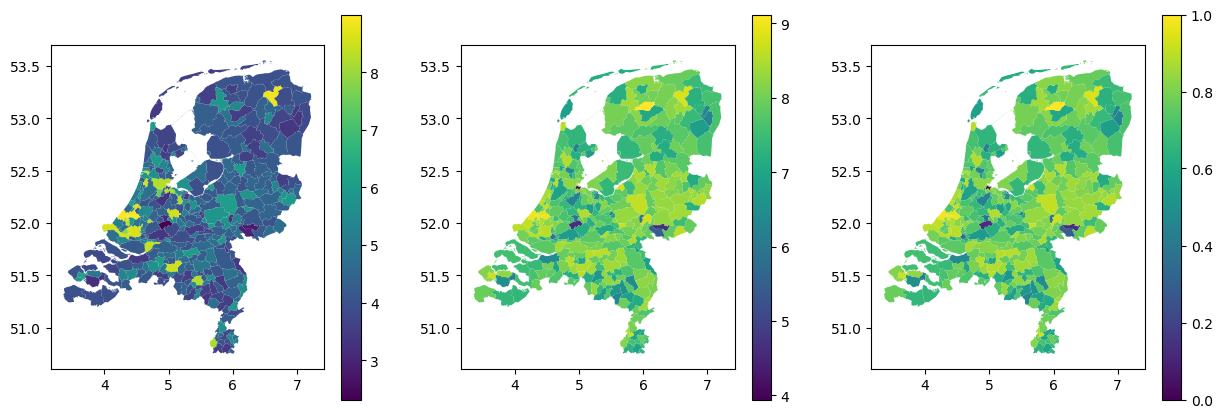

In [260]:

measure = "altieri"

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

gm.plot(column=f'L1_{measure}_1_T', ax=ax[0], legend=True)
gm.plot(column=f'L1_{measure}_1', ax=ax[1], legend=True)
gm.plot(column=f'L1_{measure}_1_norm', ax=ax[2], legend=True)


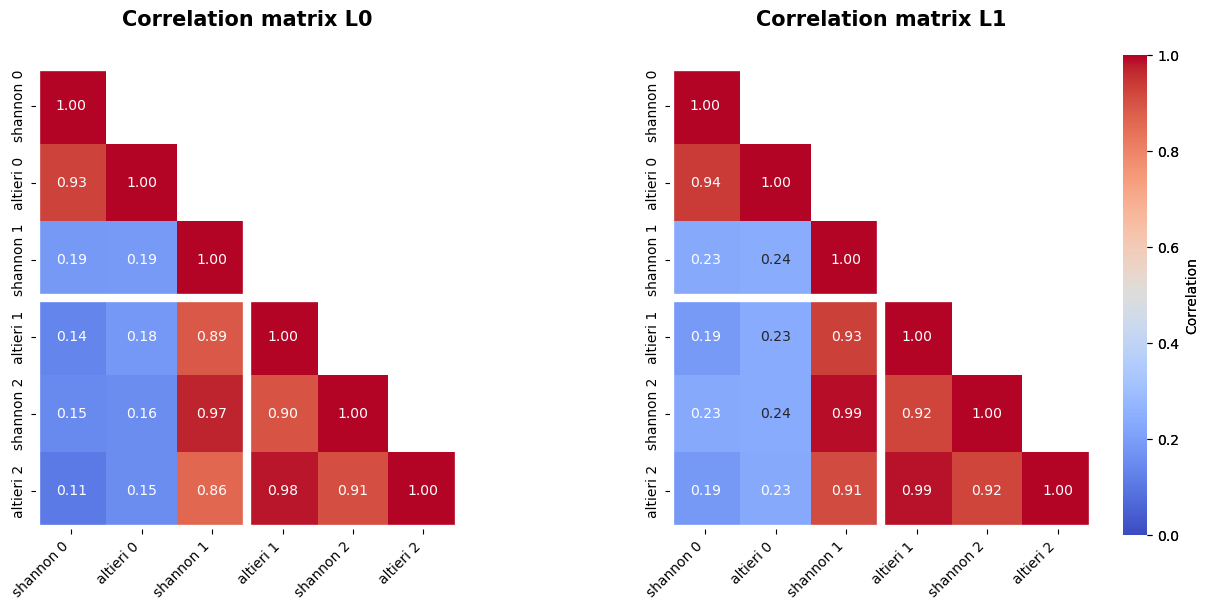

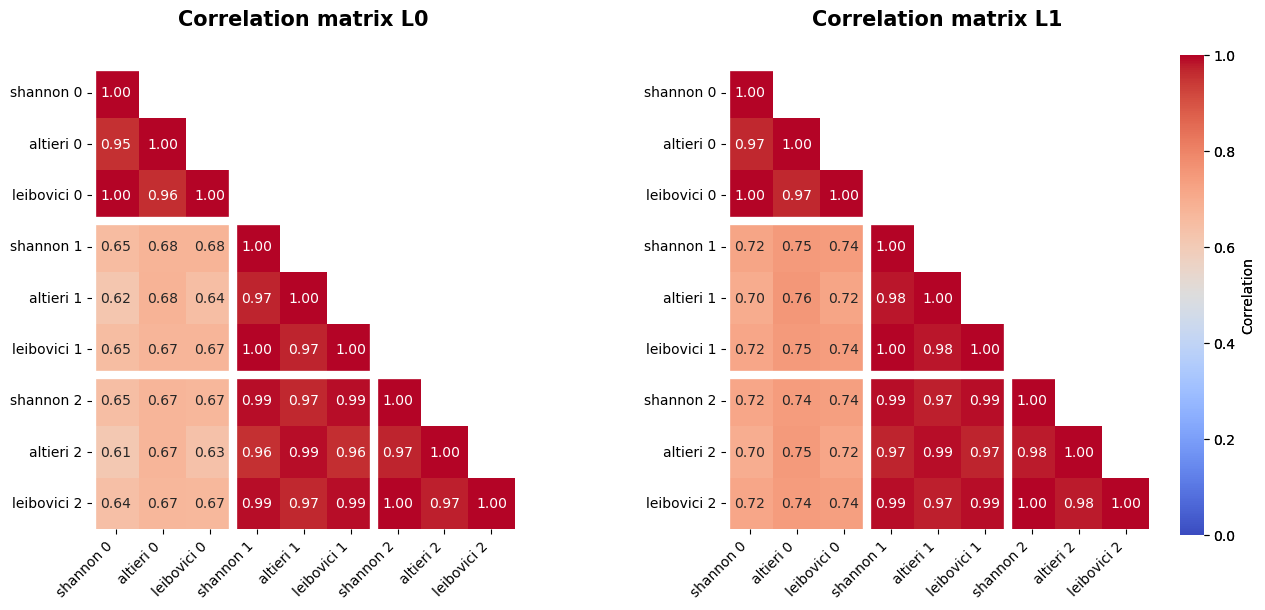

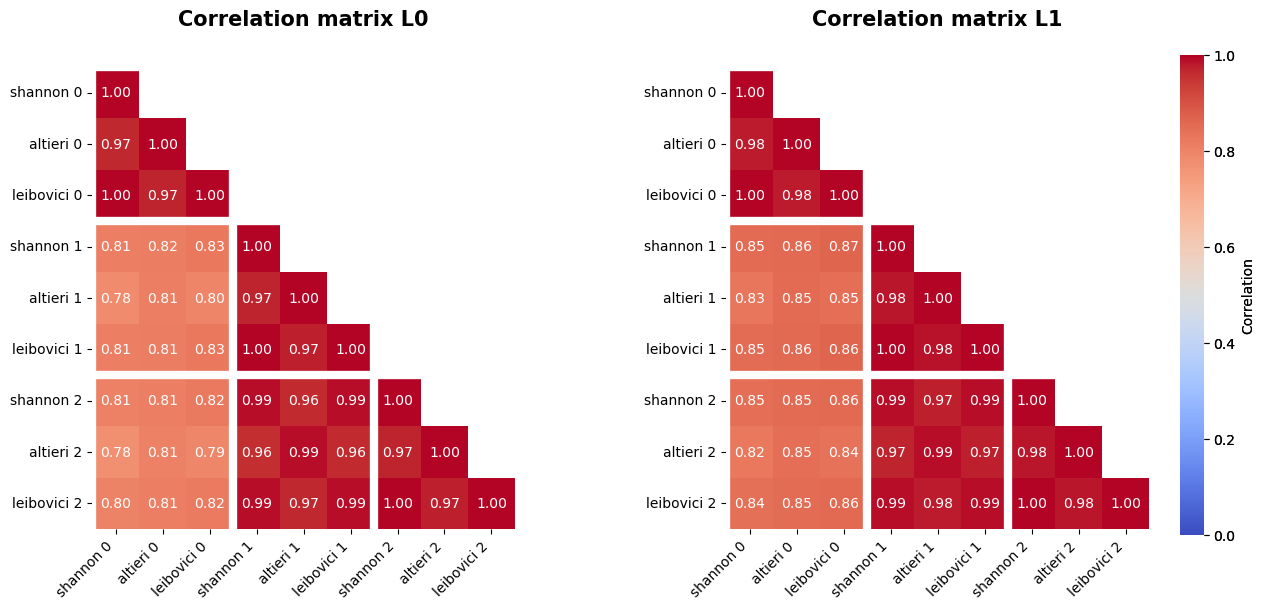

In [267]:
for gdf, scale in zip([gm, wk, bu], ['gm', 'wk', 'bu']):
    # regex all L0_x_x_norm columns
    regex = re.compile(r'L0_(shannon|altieri|leibovici)_\d{1}_norm')


    # make correlation matrix
    correlation = gdf.filter(regex='_norm$').corr()

    if 'L0_leibovici_0_norm' in correlation.columns:
        col_order_1 = [
                    'L0_shannon_0_norm',
                    'L0_altieri_0_norm', 
                    'L0_leibovici_0_norm',
                    'L0_shannon_1_norm',  
                    'L0_altieri_1_norm',
                    'L0_leibovici_1_norm',
                    'L0_shannon_2_norm', 
                    'L0_altieri_2_norm',
                    'L0_leibovici_2_norm',
                    ]
        col_order_2 = [
                    'L1_shannon_0_norm',
                    'L1_altieri_0_norm',
                    'L1_leibovici_0_norm',
                    'L1_shannon_1_norm',
                    'L1_altieri_1_norm',
                    'L1_leibovici_1_norm', 
                    'L1_shannon_2_norm',  
                    'L1_altieri_2_norm',  
                    'L1_leibovici_2_norm'
        ]
    else:
        col_order_1 = [
                    'L0_shannon_0_norm',
                    'L0_altieri_0_norm', 
                    'L0_shannon_1_norm',  
                    'L0_altieri_1_norm',
                    'L0_shannon_2_norm', 
                    'L0_altieri_2_norm',
                    ]
        col_order_2 = [
                    'L1_shannon_0_norm',
                    'L1_altieri_0_norm',
                    'L1_shannon_1_norm',
                    'L1_altieri_1_norm', 
                    'L1_shannon_2_norm',  
                    'L1_altieri_2_norm',  
        ]

    correlation_l0 = correlation.loc[col_order_1, col_order_1]
    correlation_l1 = correlation.loc[col_order_2, col_order_2]

    # rename columns to exclude L0, L1 and _norm
    correlation_l0.columns = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l0.columns]
    correlation_l0.index = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l0.index]
    correlation_l1.columns = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l1.columns]
    correlation_l1.index = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l1.index]

    # plot correlation matrix with index and column names as labels, include legend
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i, correlation in enumerate([correlation_l0, correlation_l1]):
        
        mask = np.triu(np.ones_like(correlation.corr()), k=1)
        heatmap = sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation'}, mask=mask, vmin=0, vmax=1, ax=ax[i])
        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

        # move colorbar a bit to the right
        cbar = heatmap.collections[0].colorbar 
        # adjust cbar position
        cbar.ax.set_position([0.85, 0, 0.016, 1])

        # set title
        heatmap.set_title(f'Correlation matrix L{i}', fontsize=15, fontweight='bold', pad=30)

        # make group markings on the heatmap
        for i in range(3):
            heatmap.axvline(i*3, color='white', lw=6)
            heatmap.axhline(i*3, color='white', lw=6)
    
    plt.savefig(f'plots/correlation_{scale}_matrix.png', dpi=300)
